In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## *Importing and Distributing Data*

In [110]:
musics = pd.read_csv('TASK2_dataset.csv')
print(musics.head())


key1 = list(set(musics.keyword_1))
key2 = musics.keyword_2.unique()
key3 = musics.keyword_3.unique()

count = len(musics.genre)

   song_id keyword_1  keyword_2  keyword_3      genre
0       74    guitar      happy  distorted       rock
1      103     brass  energetic    melodic  classical
2      201     banjo      happy   acoustic    country
3      194     synth  energetic      heavy    hip-hop
4      184     synth  energetic       slow    hip-hop


# *Vectorisation*

## BOW

In [111]:
key_BOW_1 = np.zeros((count,len(key1)))
key_BOW_2 = np.zeros((count,len(key2)))
key_BOW_3 = np.zeros((count,len(key3)))


for i in range(count):
    for j in range(len(key1)):
        if key1[j] in musics.keyword_1[i]:
            key_BOW_1[i][j] += 1
    
    for j in range(len(key2)):
        if key2[j] in musics.keyword_2[i]:
            key_BOW_2[i][j] += 1
    
    for j in range(len(key3)):
        if key3[j] in musics.keyword_3[i]:
            key_BOW_3[i][j] += 1
            

## TF-IDF

In [112]:
tf_1 = np.copy(key_BOW_1)/3
tf_2 = np.copy(key_BOW_2)/3
tf_3 = np.copy(key_BOW_3)/3

idf_1 = np.zeros(len(key1))
idf_2 = np.zeros(len(key2))
idf_3 = np.zeros(len(key3))

for i in range(len(key1)):
    idf_1[i] = np.log((count+1)/sum(tf_1[:,i]+1))
for i in range(len(key2)):
    idf_2[i] = np.log((count+1)/sum(tf_2[:,i]+1))
for i in range(len(key3)):
    idf_3[i] = np.log((count+1)/sum(tf_3[:,i]+1))
    
tfidf_1 = tf_1 * idf_1
tfidf_2 = tf_2 * idf_2
tfidf_3 = tf_3 * idf_3

# *PCA*

In [113]:
def pca(set):
    temp = set - np.mean(set)
    temp = set / np.std(set)
    
    temp = np.cov (temp.T)
    
    eigenval , eigenvect = np.linalg.eig(temp)
    
    index = np.argsort(eigenval)[::-1]
    eigenvect = eigenvect[:,index[0:2]]
    
    temp = set @ eigenvect
    
    return temp
    
    

pca_1 = pca(tfidf_1)
pca_2 = pca(tfidf_2)
pca_3 = pca(tfidf_3)

pcas = (pca_1+pca_2+pca_3)/3

# *K-Means*

In [114]:
np.random.seed(42)  

cents = 6
centroids = pcas[np.random.choice(range(len(pcas)),cents , replace=False)]

for i in range(100):
    distances = np.linalg.norm(pcas[:, np.newaxis] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)

    new_centroids = np.array([pcas[labels == j].mean(axis=0) for j in range(cents)])

    if np.all(centroids == new_centroids):
       break

    centroids = new_centroids

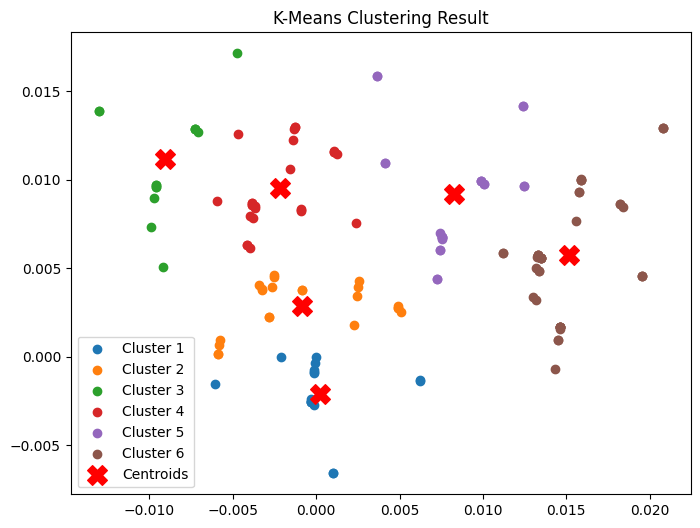

In [115]:
plt.figure(figsize=(8, 6))
for i in range(cents):
    plt.scatter(pcas[labels == i][:, 0], pcas[labels == i][:, 1], label=f"Cluster {i+1}")
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', color='red', s=200, label="Centroids")
plt.legend()
plt.title("K-Means Clustering Result")
plt.show()

In [116]:
musics["Cluster"] = labels  # Add cluster assignments to the original dataset

# Count number of songs per genre in each cluster
genre_distribution = musics.groupby(["Cluster", "genre"]).size().unstack().fillna(0)

# Convert counts to percentages
genre_distribution = genre_distribution.div(genre_distribution.sum(axis=1), axis=0) * 100

# Display results
print(genre_distribution)

genre    classical    country    hip-hop        pop       rock
Cluster                                                       
0        64.705882  17.647059   0.000000  17.647059   0.000000
1        54.545455  13.636364  18.181818  13.636364   0.000000
2         7.142857   0.000000  57.142857  35.714286   0.000000
3         7.692308   0.000000  65.384615  26.923077   0.000000
4         4.347826  34.782609   4.347826  17.391304  39.130435
5         0.000000  33.333333   0.000000  20.000000  46.666667


In [ ]:
import numpy as np

def silhouette_score(X, labels):
    """
    Computes the silhouette score for a given clustering result.
    
    Parameters:
        X (numpy array): The dataset (n_samples, n_features)
        labels (numpy array): Cluster labels for each sample

    Returns:
        float: The silhouette score
    """
    n = X.shape[0]  # Number of points
    unique_clusters = np.unique(labels)  # Unique cluster labels
    silhouette_scores = np.zeros(n)  # Store silhouette values for each point

    for i in range(n):
        own_cluster = labels[i]
        own_cluster_points = X[labels == own_cluster]

        # Compute a(i): Mean intra-cluster distance
        if len(own_cluster_points) > 1:
            a_i = np.mean([np.linalg.norm(X[i] - p) for p in own_cluster_points if not np.array_equal(X[i], p)])
        else:
            a_i = 0  # If only one point in cluster, set a(i) = 0

        # Compute b(i): Mean nearest-cluster distance
        b_i = float('inf')
        for cluster in unique_clusters:
            if cluster == own_cluster:
                continue
            other_cluster_points = X[labels == cluster]
            mean_dist = np.mean([np.linalg.norm(X[i] - p) for p in other_cluster_points])
            b_i = min(b_i, mean_dist)  # Choose nearest cluster

        # Compute silhouette score for point i
        silhouette_scores[i] = (b_i - a_i) / max
